In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import gensim
import matplotlib.pyplot as pyplot
from sklearn.manifold import TSNE
from keras import metrics
from sklearn import metrics

c:\users\himani soni\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\himani soni\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [1]:

EMBEDDING_FILE=f'E:/glove/glove.twitter.27B.100d.txt'
embed_size = 100 # how big is each word vector
max_features = 10000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a comment to use

train = pd.read_csv('en_training_csv.csv',engine='python')
X = train["text"]
y = train["HS"]


tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
list_tokenized_train = tokenizer.texts_to_sequences(X)
X = pad_sequences(list_tokenized_train, maxlen=maxlen)


def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE,encoding= 'utf-8'))
word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


NameError: name 'pd' is not defined

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 50, 200)           160800    
_________________________________________________________________
global_max_pooling1d_25 (Glo (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 201       
Total params: 1,161,001
Trainable params: 1,161,001
Non-trainable params: 0
_________________________________________________________________
None
Train on 6885 samples, validate on 1215 samples
Epoch 1/3
6885/6885 [==============================] - 50s 7ms/step - loss: 0.5

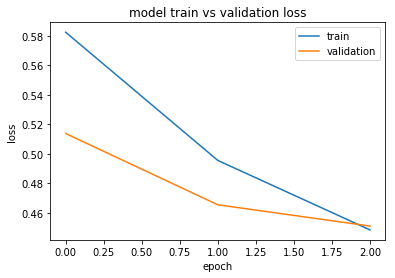

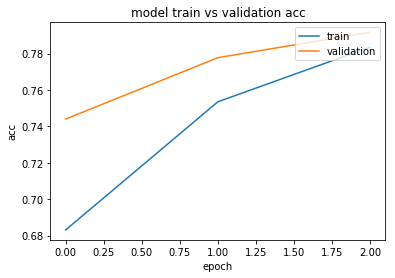

In [44]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
x = GlobalMaxPool1D()(x)
#x = Dropout(0.5)(x)
#x = Dense(50, activation="relu")(x)
#x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
print(model.summary())
#model.fit(X_train, y_train, batch_size=18, epochs=10)
history =model.fit(X_train, y_train, batch_size=16, epochs=3, validation_split=0.15)

print("Test-acc:", np.mean(history.history["val_acc"]))
y_predicted =  model.predict([X_test],batch_size=18)
print("f1_score categorys: %.2f" %np.average(f1_score(y_test,y_predicted.round(), average=None)))
    #print(classification_report(y_test,y_predicted))
    #f1_scores.append(np.average(f1_score(y_test,y_predicted, average=None)))

# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()


In [4]:
accuracy_scores = []
def predictFromData(X_train, X_test, y_train, y_test):
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
    x = GlobalMaxPool1D()(x)
    #x = Dropout(0.5)(x)
    #x = Dense(50, activation="relu")(x)
    #x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
    print(model.summary())
    model.fit(X_train, y_train, batch_size=16, epochs=3)
    y_predicted =  model.predict([X_test],batch_size=16)
    y_predicted = (y_predicted > 0.5)
    print("f1_score categorys: %.2f" %np.average(f1_score(y_test,y_predicted, average=None)))
    accuracy_scores.append(np.average(f1_score(y_test,y_predicted.round(), average=None)))

In [5]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.15)
for train, test in sss.split(X,y):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    #print(len(X_train), len(X_test), len(y_train), len(y_test))
    predictFromData(X_train,X_test,y_train,y_test)


print('f1', np.average(accuracy_scores))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           160800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 1,161,001
Trainable params: 1,161,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
7650/7650 [==============================] - 44s 6ms/step - loss: 0.5713 - acc: 0.6963
Epoch 2/3
7650/7650 [=========

Epoch 1/3
7650/7650 [==============================] - 49s 6ms/step - loss: 0.5665 - acc: 0.7047
Epoch 2/3
7650/7650 [==============================] - 47s 6ms/step - loss: 0.4826 - acc: 0.7703
Epoch 3/3
7650/7650 [==============================] - 47s 6ms/step - loss: 0.4359 - acc: 0.7976
f1_score categorys: 0.77
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 200)           160800    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)         

In [16]:


EMBEDDING_FILE=f'E:/glove/glove.twitter.27B.100d.txt'
embed_size = 100 # how big is each word vector
max_features = 10000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a comment to use

train = pd.read_csv('en_training_csv.csv',engine='python')
X = train["text"]
y = train["HS"]

tweets_test_data = pd.read_csv('en_dev_csv.csv',engine='python')
test = tweets_test_data['text']

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
list_tokenized_train = tokenizer.texts_to_sequences(X)
list_tokenized_test = tokenizer.texts_to_sequences(test)
X = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)


def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE,encoding= 'utf-8'))
word_index = tokenizer.word_index
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [20]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
x = GlobalMaxPool1D()(x)
#x = Dropout(0.5)(x)
#x = Dense(50, activation="relu")(x)
#x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
print(model.summary())
model.fit(X, y, batch_size=16, epochs=5)
y_predicted =  model.predict([X_test],batch_size=16)
y_predicted = (y_predicted.round())

print(y_predicted)
print("f1_score categorys: %.2f" %np.average(f1_score(tweets_test_data['HS'],y_predicted, average=None)))
print("f1_score categorys: %.2f" %np.average(f1_score(tweets_test_data['HS'],y_predicted[:,0].astype(int), average=None)))
en_a = pd.DataFrame({"id":tweets_test_data['id'],"hs":y_predicted[:,0].astype(int)})
en_a.to_csv("en_a.tsv",sep = '\t', index=False) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 50, 200)           160800    
_________________________________________________________________
global_max_pooling1d_22 (Glo (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 201       
Total params: 1,161,001
Trainable params: 1,161,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
9000/9000 [==============================] - 71s 8ms/step - loss: 0.5635 - acc: 0.7022
Epoch 2/5
9000/9000 [=========

# Test

In [9]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

In [10]:
EMBEDDING_FILE=f'E:/glove/glove.twitter.27B.100d.txt'
embed_size = 100 # how big is each word vector
max_features = 10000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a comment to use

In [12]:
train = pd.read_csv("en_training_csv.csv", engine="python")
X = train["text"]
y = train["HS"]

In [4]:
test = pd.read_csv('en_dev_csv.csv',engine='python')
X_test = test["text"]
y_test = test["HS"]
#X_test,y_test = remove_data(test,"text","HS")
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [13]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10)
for train, test in sss.split(X,y):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

print(len(X_train), len(X_test), len(y_train), len(y_test))

8100 900 8100 900


In [14]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [15]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE,encoding= 'utf-8'))
#all_embs = np.stack(embeddings_index.values())
#emb_mean,emb_std = all_embs.mean(), all_embs.std()
#emb_mean,emb_std

In [16]:
word_index = tokenizer.word_index
#print(all_embs = np.stack(embeddings_index.values()))


In [17]:
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix)
                
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.095152    0.37024     0.54290998 ... -0.51082999  0.46877
   0.34882   ]
 [ 0.15866999  0.75759    -0.60250002 ...  0.25136     0.03094
  -0.36386999]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.28492001 -0.46737     0.38525    ...  0.63011003 -0.78134
  -0.18414   ]]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 100)           60400     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total para

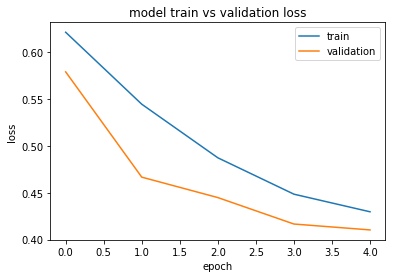

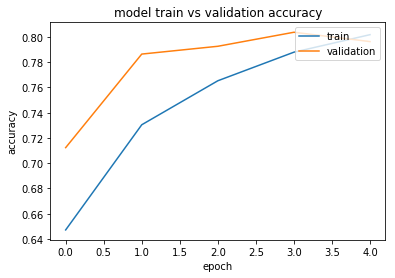

In [19]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
x = GlobalMaxPool1D()(x)
#x = Dropout(0.5)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
print(model.summary())
#model.fit(X_train, y_train, batch_size=18, epochs=10)
history =model.fit(X_train, y_train, batch_size=18, epochs=5, validation_split=0.10)

print("Test-Accuracy:", np.mean(history.history["val_acc"]))
y_predicted =  model.predict([X_test],batch_size=18)
print("Accuracy: %.2f" %accuracy_score(y_test,y_predicted.round()))

# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()
